# Continual Learning
### La (necessaria) rivoluzione del Machine Learning


##### Machine Learning Journal Club - https://www.mljc.it/
##### Luca Bottero - luca.bottero192@edu.unito.it

## 1 - Motivazioni

E' un fatto ben noto che il Machine Learning è in grado di fornire una soluzione a problemi computazionalmente estremamente complessi
con risultati stupefacenti (a volte superando il benchmark umano di riferimento). Il ML è *de facto* lo standard per molte applicazioni
di grande interesse industriale e di consumo, in un contesto di forte crescita sia della qualità dei risultati sia della quantità di 
scenari dove la sua applicazione risulta vantaggiosa.

#### Machine Vision
Tra i risultati più notevoli del ML vi è sicuramente il suo impiego come strumento di Machine Vision: nella sua forma più elementare, un'immagine (matrice
di intensità del segnale sui pixel) viene classificata all'interno di un insieme **finito e determinato** di categorie. Adottando modelli più complessi 
è possibile ottenere il cosidetto "Masking" (classificazione di determinate aree dell'immagine come appartenenti a specifiche oggetti), fino ad arrivare alla
"Image Caption Generation", alla "Image Question Answering" e ad altro ancora.

Lavorare con le immagini presenta diverse difficoltà, in primis le dimensioni dei dataset ($ O(10^2) $ GB per ImageNet) e il grande carico computazionale
dei modelli impiegati (che possono facilmente superare le decine di ore su hardware specializzato). Esistono anche problematiche etiche e legali, che tuttavia
non discutiamo.

Per ovviare a tali problemi, si può fare ricorso a un dataset dalle dimensioni contenute. La scelta standard in tal senso è il dataset MNIST

torch.Size([1000, 1, 28, 28])


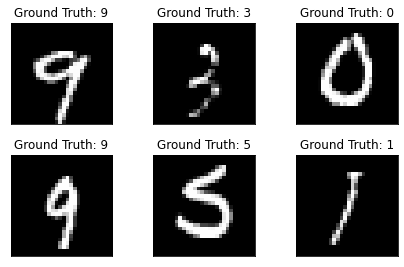

In [2]:
import torch
import torchvision

batch_size_train = 64
batch_size_test = 1000

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  fig.set_facecolor('white')

plt.show()



Immaginiamo ora la seguente situazione: è necessario sviluppare un modello che riconosca la differenza tra le cifre 0 e 1. Dato che si tratta di un problema piuttosto semplice, decidiamo di costruire una rete neurale multistrato semplice, un percettrone. Impostiamo i dataloader, creiamo un modello e verifichiamo l'efficiacia del nostro approccio:

In [3]:
import copy

idx_0 = train_dataset.targets == 0
idx_1 = train_dataset.targets == 1

idx = idx_0 | idx_1

print(idx_0.nonzero().shape)
print(idx_1.nonzero().shape)
print(idx.nonzero().shape)

train_dataset_01 = copy.deepcopy(train_dataset)
train_dataset_01.targets = train_dataset_01.targets[idx]
train_dataset_01.data = train_dataset_01.data[idx]

train_loader_01 = torch.utils.data.DataLoader(train_dataset_01, batch_size=batch_size_train, shuffle=True)


idx_0 = test_dataset.targets == 0
idx_1 = test_dataset.targets == 1

idx = idx_0 | idx_1

print(idx_0.nonzero().shape)
print(idx_1.nonzero().shape)
print(idx.nonzero().shape)

test_dataset_01 = copy.deepcopy(test_dataset)
test_dataset_01.targets = test_dataset_01.targets[idx]
test_dataset_01.data = test_dataset_01.data[idx]

test_loader_01 = torch.utils.data.DataLoader(test_dataset_01, batch_size=batch_size_test, shuffle=True)


torch.Size([5923, 1])
torch.Size([6742, 1])
torch.Size([12665, 1])
torch.Size([980, 1])
torch.Size([1135, 1])
torch.Size([2115, 1])


L'operazione sopra poteva essere svolta in modo leggermente più rapido, tuttavia è evidente che il processo è piuttosto macchinoso. La rete neurale è definita come segue:

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x1 = F.relu(x)
        x = self.fc2(x1)
        x2 = F.relu(x)

        return F.log_softmax(self.fc3(x2), dim=1)

Il nostro modello elementare ha due layer e ha la funzione ReLu come attivazione. Dato che si tratta di un problema di classificazone, usiamo log_softmax come funzione di penalizzazione.
Definiamo ora le funzioni per eseguire l'allenamento e la valutazione del nostro modello:

In [5]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    #model.train()

    with tqdm(train_loader, unit = 'batch') as tepoch:
        mean_loss = 0
        for num_tepoch, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            mean_loss += loss.item()

            tepoch.set_postfix(loss=mean_loss/(num_tepoch + 1))
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return((test_loss, 100. * correct / len(test_loader.dataset)))

In [6]:
import torch.optim as optim

use_cuda = False
save_model  = True
epochs      = 5
lr          = 1e-2

device = torch.device("cuda" if use_cuda else "cpu")

model_01 = SimpleNet().to(device)

optimizer = optim.Adadelta(model_01.parameters(), lr = lr)


In [7]:
for epoch in (range(1, epochs + 1)):
    train(model_01, device, train_loader_01, optimizer, epoch)
    test(model_01, device, test_loader_01)


  4%|▍         | 8/198 [00:00<00:02, 79.00batch/s, loss=0.134]


Test set: Average loss: 0.1364, Accuracy: 2106/2115 (100%)



  4%|▎         | 7/198 [00:00<00:03, 60.31batch/s, loss=0.0279]


Test set: Average loss: 0.0299, Accuracy: 2109/2115 (100%)



  5%|▍         | 9/198 [00:00<00:02, 80.39batch/s, loss=0.0214]


Test set: Average loss: 0.0145, Accuracy: 2112/2115 (100%)



  4%|▍         | 8/198 [00:00<00:02, 71.98batch/s, loss=0.0109]


Test set: Average loss: 0.0097, Accuracy: 2112/2115 (100%)



100%|██████████| 198/198 [00:02<00:00, 68.22batch/s, loss=0.0113]



Test set: Average loss: 0.0074, Accuracy: 2113/2115 (100%)



Nonostante l'estrema semplicità del nostro modello siamo comunque riusciti a ottenere un'accuratezza >99% in pochi secondi (com'era prevedibile). Fin'ora siamo ben dentro il classico dominio del ML e non abbiamo visto niente di nuovo rispetto a una semplice introduzione alle basi delle reti neurali.
Immaginiamo ora di voler ampliare lo spettro d'applicazione del nostro modello aggiungendo la possibilità di classificare una terza cifra, ovvero il numero 2.

Considerando il fatto che possediamo ancora i dati relativi alle due cifre, ci limitiamo a eseguire nuovamente l'allenamento, aggiungendo al dataset le nuove immagini.

Iniziamo ripetendo la procedura effettuata in precedenza per creare i dataloader:

In [8]:
idx_0 = train_dataset.targets == 0
idx_1 = train_dataset.targets == 1
idx_2 = train_dataset.targets == 2

idx = idx_0 | idx_1 | idx_2

print(idx_0.nonzero().shape)
print(idx_1.nonzero().shape)
print(idx_2.nonzero().shape)
print(idx.nonzero().shape)

train_dataset_012 = copy.deepcopy(train_dataset)
train_dataset_012.targets = train_dataset_012.targets[idx]
train_dataset_012.data = train_dataset_012.data[idx]

train_loader_012 = torch.utils.data.DataLoader(train_dataset_012, batch_size=batch_size_train, shuffle=True)


idx_0 = test_dataset.targets == 0
idx_1 = test_dataset.targets == 1
idx_2 = test_dataset.targets == 2

idx = idx_0 | idx_1 | idx_2

print(idx_0.nonzero().shape)
print(idx_1.nonzero().shape)
print(idx_2.nonzero().shape)
print(idx.nonzero().shape)

test_dataset_012 = copy.deepcopy(test_dataset)
test_dataset_012.targets = test_dataset_012.targets[idx]
test_dataset_012.data = test_dataset_012.data[idx]

test_loader_012 = torch.utils.data.DataLoader(test_dataset_012, batch_size=batch_size_test, shuffle=True)

torch.Size([5923, 1])
torch.Size([6742, 1])
torch.Size([5958, 1])
torch.Size([18623, 1])
torch.Size([980, 1])
torch.Size([1135, 1])
torch.Size([1032, 1])
torch.Size([3147, 1])


Notiamo che il processo, già macchinoso la prima volta, diventa insostenibile qualora lo si dovesse scalare a grande scala. Appare evidente la necessità di creare un metodo più efficiente per caricare i dati in questo modo.

Incappiamo ora in un secondo problema: il nostro modello possiede due soli neuroni in output. Occorre quindi **cambiare la topologia della rete neurale**, ovvero modificare il numero di neuroni in uno dei suoi strati, in questo caso l'ultimo. Come fare? Diversi approcci sono possibili. Il più semplice consiste nell'istanziare un nuovo modello avente il numero giusto di neuroni d'uscita. Tuttavia, così facendo si paga un costo enorme: perdiamo totalmente ogni contributo dato dal precedente allenamento. Alla fine dei conti, stiamo semplicemente ripetendo la procedura di addestramento *ex novo*, non usando i risultati ottenuti precedentemente. Ovviamente, questa tecnica "assicura" la risucita dell'addestramento, motivo per il quale è presa da riferimento con il quale valutare l'efficacia degli algoritmi di CL. Questo approccio è detto **incremental learning**, ovvero "bariamo e riaddestriamo da zero" (che è ciò che vogliamo evitare facendo CL).

In [9]:
class SimpleNet_again(nn.Module):
    def __init__(self):
        super(SimpleNet_again, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x1 = F.relu(x)
        x = self.fc2(x1)
        x2 = F.relu(x)

        return F.log_softmax(self.fc3(x2), dim=1)

epochs      = 5
lr          = 1e-2

model_012 = SimpleNet_again().to(device)

optimizer = optim.Adadelta(model_012.parameters(), lr = lr)

for epoch in (range(1, epochs + 1)):
    train(model_012, device, train_loader_012, optimizer, epoch)
    test(model_012, device, test_loader_012)


  3%|▎         | 8/291 [00:00<00:03, 73.04batch/s, loss=0.26] 


Test set: Average loss: 0.2562, Accuracy: 2977/3147 (95%)



  2%|▏         | 6/291 [00:00<00:04, 58.10batch/s, loss=0.116]


Test set: Average loss: 0.1235, Accuracy: 3060/3147 (97%)



  2%|▏         | 7/291 [00:00<00:04, 63.79batch/s, loss=0.0857]


Test set: Average loss: 0.0889, Accuracy: 3080/3147 (98%)



  2%|▏         | 6/291 [00:00<00:05, 56.68batch/s, loss=0.0773]


Test set: Average loss: 0.0715, Accuracy: 3096/3147 (98%)



100%|██████████| 291/291 [00:04<00:00, 61.33batch/s, loss=0.0739]



Test set: Average loss: 0.0627, Accuracy: 3097/3147 (98%)



Come prima, anche qui otteniamo un risultato molto buono in poco tempo. Tuttavia non siamo soddisfatti. Per quanto funzionale (sulla nostra piccola e irrealistica scala), questo approccio è inefficiente, inelegante e difficilmente scalabile. Vogliamo trovare un modo di sfruttare l'addestramento precedente della rete neurale, in modo (si spera!) di aumentare le prestazioni. Un approccio sensato è quello di considerare come delle scatole nere tutto ciò che procede l'ultimo (o gli ultimi) strati della rete neurale: gli strati intermedi vengono detti "estrattori di caratteristiche" (features extractors), mentre gli ultimi vengono detti "classificatori". Ipersemplificando, i considera quindi l'insieme degli strati intermedi come una serie di applicazioni geometriche che trasformano gli input in una loro rappresentazione all'interno di uno spazio a dimensione differente, le cui caratteristiche metriche descrivono il "grado di seprazione" tra diversi sample mostrati in fase di addestramento. Lo strato di classificazione mappa questa rappresentazione sullo spazio di output.

Si potrebbe quindi modificare solo il classificatore (strato finale), lasciando inalterato l'estrattore di feature. Così facendo abbiamo implicitamente assunto che la topologia dello spazio delle feature (ottenuta dagli stati intermedi) possa "accomodare" in maniera corretta e significativa i nuovi dati. Solo l'esperimento può dimostarcelo:

In [10]:
model_01_last_modified = copy.deepcopy(model_01)

n_layers = len(list(model_01_last_modified.parameters()))

for i,params in enumerate(model_01_last_modified.parameters()):
    if i != n_layers - 1:
        params.requires_grad = False

for i,params in enumerate(model_01_last_modified.parameters()):
    print(params.requires_grad)


False
False
False
False
False
True


In [11]:
modules = model_01_last_modified._modules
last_module_name = list(modules.keys())[-1]

model_01_last_modified._modules[last_module_name] = nn.Linear(64,3)

for child in model_01_last_modified.children():
    print(child)


Linear(in_features=784, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=3, bias=True)


In [12]:
epochs      = 5
lr          = 1e-2

optimizer = optim.Adadelta(model_01_last_modified.parameters(), lr = lr)

for epoch in (range(1, epochs + 1)):
    train(model_01_last_modified, device, train_loader_012, optimizer, epoch)
    test(model_01_last_modified, device, test_loader_012)

  3%|▎         | 8/291 [00:00<00:03, 70.82batch/s, loss=1.08]


Test set: Average loss: 1.0926, Accuracy: 1831/3147 (58%)



  3%|▎         | 8/291 [00:00<00:03, 75.00batch/s, loss=0.801]


Test set: Average loss: 0.8094, Accuracy: 1681/3147 (53%)



  2%|▏         | 7/291 [00:00<00:04, 68.97batch/s, loss=0.651]


Test set: Average loss: 0.6535, Accuracy: 2343/3147 (74%)



  2%|▏         | 7/291 [00:00<00:04, 68.25batch/s, loss=0.546]


Test set: Average loss: 0.5665, Accuracy: 2418/3147 (77%)



100%|██████████| 291/291 [00:04<00:00, 62.85batch/s, loss=0.534]



Test set: Average loss: 0.5099, Accuracy: 2513/3147 (80%)



Verifichiamo brevemente che i layer intermedi non sono stati modificati:

In [13]:
for original,modified in zip(model_01.parameters(), model_01_last_modified.parameters()):
    try:
        print(original == modified)
    except Exception as e:
        print(e)


tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True,

Il risultato ottenuto non è buono quanto il valore di riferimento. Probabilmente la cause è da ricercarsi nella semplicità del nostro modello, tuttavia questo approccio ha dei limiti intrinsechi: non è detto che lo spazio delle feature imparate su di un specifico insieme di dati sia "valido" anche per dati fuori dalla distribuzione originale. Questo approccio è alla base del cosiddetto **transfer learning**, che non approfondiamo in questa sede.

Vogliamo però notare che abbiamo già ottenuto un piccolo vantaggio (nonostante un basso rendimento complessivo): la velocità del training è quasi raddoppiata, com'è ovvio considerando che stiamo aggiornando un sottoinsieme piuttosto piccolo di parametri.

## 2 - Sviluppo

### Accesso limitato ai dati

Fin'ora abbiamo avuto un grande vantaggio: i dati a nostra disposizione rimanevano tali per sempre. A primo avviso può sembrare naturale, percezione data dalla relativa facilità di stoccaggio dei dati per progetti amatoriali. Tuttavia, il costo dello stoccaggio di dati non può essere trascurato in caso di modelli estremamente complessi. Dato che il valore del ML è direttamente proporzionale alla complessità dei problemi che permette di affrontare, è di fondamentale importanza comprendere l'alto costo dell'immagazzinamento dei dati. 

Ogni giorno, le decine di satelliti metereologici che orbitano intorno al nostro pianeta raccolgo TB di dati relativi alle condizioni fisiche e chimiche dell'atmosfera e della superficie del pianeta. La maggior parte di questi dati viene impiegata per eseguire delle previsioni metereologiche, tuttavia solo una parte piuttosto esigua viene immagazzinata con la risoluzione massima. La maggior parte dei dati viene salvata con una risoluzione spaziale nettamente inferiore. Vengono quindi perse immense quantità di dati ogni giorno, poichè il costo dell'immagazzinamento sarebbe proibitivo (e probabilmente l'output globale di memorie informatiche dovrebbe aumentare di molto per poter sostenere la richiesta, cosa ovvia impossibile).

Immaginiamo di sviluppare un robot umanoide che debba interagire con gli umani e con l'ambiente circostante. Esso deve imparare tramite l'esperienza delle informazioni che non solo non sono conosciute a priori, ma non sono *conoscibili* a priori: l'ambiente è in perenne mutamento, così come gli oggetti e le interazioni tra essi. Risulta quindi essenziale una capacità di astrazione tale da permettere l'apprendimento e il riconoscimento in maniera continuativa ("non si smette mai di imparare"). Immaginiamo di dotare il nostro robot di un imput video composto da due telecamere (per avere il senso della profondità) aventi una risoluzione di 1080p (HD) operanti a 60 FPS: produrremmo svariate decine di GB al giorno solo di dati video (assumendo di usare compressione video). Diventerebbe presto impraticabile immagazzinare tutti i dati in locale (nel robot) e il costo (e l'efficienza) del sistema diminuirebbe piuttosto velocemente.

Risulta evidente l'assoluta necessità di migliorare lo stato delle cose. D'ora in poi assumeremo che i dati di addestramento diventeranno *totalmente o quasi totalmente* indisponibili una volta usati per l'addestramento. "Quasi totalmente" è un riferimento ad alcune tecniche che prevedono il salvataggio di un numero molto limitato di esempi per ogni categoria.

### Catastrophic forgetting

Perchè non continuare semplicemente l'addestramento con i nuovi dati disponibili? In effetti, *a priori* non abbiamo nessun motivo **semplice** per pensare a una drastica riduzione delle performance se adottiamo tale linea di condotta. Un rapido esempio dimostrerà l'erroneità di tale pensiero.

Continuiamo l'addestramento del nostro modello originale, dopo aver avuto cura di modificare l'ultimo strato per adattarlo alla presenza di una terza cifra:

In [14]:
model_01_continue = copy.deepcopy(model_01)

modules = model_01_continue._modules
last_module_name = list(modules.keys())[-1]

model_01_continue._modules[last_module_name] = nn.Linear(64,3)

for child in model_01_continue.children():
    print(child)

Linear(in_features=784, out_features=64, bias=True)
Linear(in_features=64, out_features=64, bias=True)
Linear(in_features=64, out_features=3, bias=True)


In [15]:
idx_2 = train_dataset.targets == 2

idx = idx_2

train_dataset_2 = copy.deepcopy(train_dataset)
train_dataset_2.targets = train_dataset_2.targets[idx]
train_dataset_2.data = train_dataset_2.data[idx]

train_loader_2 = torch.utils.data.DataLoader(train_dataset_2, batch_size=batch_size_train, shuffle=True)

idx_2 = test_dataset.targets == 2

idx = idx_2

test_dataset_2 = copy.deepcopy(test_dataset)
test_dataset_2.targets = test_dataset_2.targets[idx]
test_dataset_2.data = test_dataset_2.data[idx]

test_loader_2 = torch.utils.data.DataLoader(test_dataset_2, batch_size=batch_size_test, shuffle=True)

Addestriamo il modello usando solo i dati relativi alla cifra 2, tuttavia eseguiamo il test anche ssu tutte e tre le cifre, per osservare quanto la prestazione risenta di questo tipo di addestramento:

In [16]:
epochs      = 5
lr          = 1e-2

optimizer = optim.Adadelta(model_01_continue.parameters(), lr = lr)

for epoch in (range(1, epochs + 1)):
    train(model_01_continue, device, train_loader_2, optimizer, epoch)
    test(model_01_continue, device, test_loader_012)

  7%|▋         | 7/94 [00:00<00:01, 61.74batch/s, loss=0.119]


Test set: Average loss: 2.0398, Accuracy: 1029/3147 (33%)



  7%|▋         | 7/94 [00:00<00:01, 60.31batch/s, loss=0.022] 


Test set: Average loss: 2.9400, Accuracy: 1032/3147 (33%)



  7%|▋         | 7/94 [00:00<00:01, 61.00batch/s, loss=0.00745]


Test set: Average loss: 3.6856, Accuracy: 1032/3147 (33%)



  7%|▋         | 7/94 [00:00<00:01, 63.24batch/s, loss=0.00324]


Test set: Average loss: 4.2439, Accuracy: 1032/3147 (33%)



100%|██████████| 94/94 [00:01<00:00, 60.00batch/s, loss=0.00242]



Test set: Average loss: 4.6796, Accuracy: 1032/3147 (33%)



Non a caso questo fenomeno viene detto **catastrophic forgetting**: il modello ha completamente disimparato a discernere le cifre tra di loro, risultando in un modello sostanzialmente casuale (e inutile). Questa è l'origine di tutti i mali del Continual Learning, il peccato originale di ogni tentavo di affrancamento dalla tirannia dei dataset statici. Questo fenomeno era immaginabile anche prima dell'esecuzione di questo semplice esperimento, pensando a cosa significa la procedura di addestramento di una rete neurale per discesa del gradiente: dato che il gradiente è essenzialmente lo stesso per ogni istanza delle immagini mostrate, i paramentri della rete si sono spostati tutti nella direzione che massimizza il guadagno sui dati presentati (questo è anche il motivo per cui è essenziale una buona randomizzazione degli input durante l'addestramneot durante il ML classico).

Occore pensare a una mitigazione di questo effetto. Potremmo provare ad adottare una tecnica simile a quanto fatto in precedenza, ovvero fissare alcuni dei parametri in modo che non possano più essere cambiati. Tuttavia questo non cambierebbe il risultato finale: il classificatore "imparerà" comunque a riconoscere solamente gli ultimi dati forniti. Siamo però sulla strada giusta: il problema risiede, a quanto sembra, nella eccessiva "mobilità" del valore delle sinapsi. L'intuito ci suggerisce di trovare un modo di "fissare" i pesi in maniera che tuttavia siano sufficientemente mobili da poter continuare ad apprendere. Vorremmo quindi conferire una sorta di "viscosità" ai pesi, senza doverli fissare in maniera totale. Quale è tuttavia il giusto bilancio tra la stabilità e la plasticità dei pesi? In letteratura ci si riferisce a tale problema con la dizione "stability-plasticity dilemma" ed è uno dei nodi centrali della ricerca in ambito CL.

## 3 - Automazione

### Avalanche: and End-to-End library for Continual Learning

*Nota: alcune parti di codice riportato di seguito provengono direttamente sito di Avalanche o dal repository ufficiale di Avalanche (https://github.com/ContinualAI/avalanche)*

Prima di procedere con l'esplorazione di alcuni algoritmi di CL è opportuno avere un modo pe poter implementare le nostre idee ed eseguire i nostri esperimenti in maniera rapida, efficiente e riproducibile. La libreria Avalanche (https://avalanche.continualai.org/) rappresenta la risposta a questa esigenza. Essa presenta, oltre a un framework tale da permettere la comparazione tra diversi algoritmi pulita ed efficiente, l'implementazione di una vasta gamma di algoritmi pubblicati di CL. Impostiamo quindi un problema di CL: 

In [159]:
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,\
    loss_metrics, timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,\
    disk_usage_metrics, gpu_usage_metrics
from avalanche.models import SimpleMLP
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.strategies import Naive, Cumulative

from torch.optim import SGD
from torch.nn import CrossEntropyLoss

scenario = SplitMNIST(n_experiences=10)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes)

print(model)

# DEFINE THE EVALUATION PLUGIN and LOGGERS
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns 
# them to the strategy it is attached to.

# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('log.txt', 'w'))

# print to stdout
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    StreamConfusionMatrix(num_classes=scenario.n_classes, save_image=False),
    loggers=[interactive_logger, text_logger, tb_logger]
)

# CREATE THE STRATEGY INSTANCE
cl_strategy = Cumulative(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=128, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers=4))

SimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Starting experiment...
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
0it [00:00, ?it/s]

/home/luca/.local/lib/python3.8/site-packages/avalanche/training/plugins/evaluation.py:84: UserWarning: No benchmark provided to the evaluation plugin. Metrics may be computed on inconsistent portion of streams, use at your own risk.
  warnings.warn(


100%|██████████| 93/93 [00:01<00:00, 75.18it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1191
	Loss_MB/train_phase/train_stream/Task000 = 0.0019
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9865
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 34.74it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0017
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 11/11 [00:00<00:00, 25.37it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp001 = 5.7370
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on exper

Analizziamo le diverse parti del codice, aiutandoci con la documentazione ufficiale (https://avalanche-api.continualai.org/en/v0.1.0/):

- scenario = SplitMNIST(n_experiences = 5) : il dataset MNIST viene diviso in 10 *esperienze*, ovvero in 10 round di addestramento, ognuna contenente 10/10 = 1 classi da imparare. **Definizione** : si dice esperienza l'insieme dei dati usati in un "turno" di addestramento. Guardando il log è possibile vedere le classi che vengono imparate ad ogni round.

- model = SimpleMLP : come si vede immediatamente dall'output del modello *prima* dell'addestramento, la rete ha 10 neuroni di output. In effetti, questo modello è sostanzialmente identico a quello che abbiamo implementato noi in precedenza. Tuttavia, questo modello richiede di sapere in partenza quale sarà il numero definitivo "massimo" di task che incontrerà nella sua vita, il che rappresenta un'ovvia limitazione. Questo modello, insieme alla strategia qui presentata, è soitamente utilizzato come prestazione di riferimento per la comparazione con i veri algoritmi di CL

- cl_strategy = Cumulative : ad ogni *esperienza* vengono usati tutti i dati relativi alle precedenti esperienze. Questo è essenzialmente il metodo "classico", in cui vengono utilizzati tutti i dati precedentemente disponibili.


La struttura di base degli esperimenti di CL è essenzialmente sempre la stessa: definisco dataset e modello, scelgo una strategia di addestramento (che è ben diversa dall'ottimizzatore (come Adam, Adagrad, SGD, ...) !!!) e osservo il risultato. La difficoltà risiede nell'immaginare una coppia modello-strategia adatta allo scenario.

Osserviamo la lista degli output che ci fornisce Avalanche:
 

In [160]:
keys = list(results[0].keys())
print(keys)

['Top1_Acc_MB/train_phase/train_stream/Task000', 'Loss_MB/train_phase/train_stream/Task000', 'Top1_Acc_Epoch/train_phase/train_stream/Task000', 'Loss_Epoch/train_phase/train_stream/Task000', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000', 'Loss_Exp/eval_phase/test_stream/Task000/Exp000', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001', 'Loss_Exp/eval_phase/test_stream/Task000/Exp001', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp002', 'Loss_Exp/eval_phase/test_stream/Task000/Exp002', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp003', 'Loss_Exp/eval_phase/test_stream/Task000/Exp003', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp004', 'Loss_Exp/eval_phase/test_stream/Task000/Exp004', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp005', 'Loss_Exp/eval_phase/test_stream/Task000/Exp005', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp006', 'Loss_Exp/eval_phase/test_stream/Task000/Exp006', 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp007', 'Loss_Exp/eval_phase/test_s

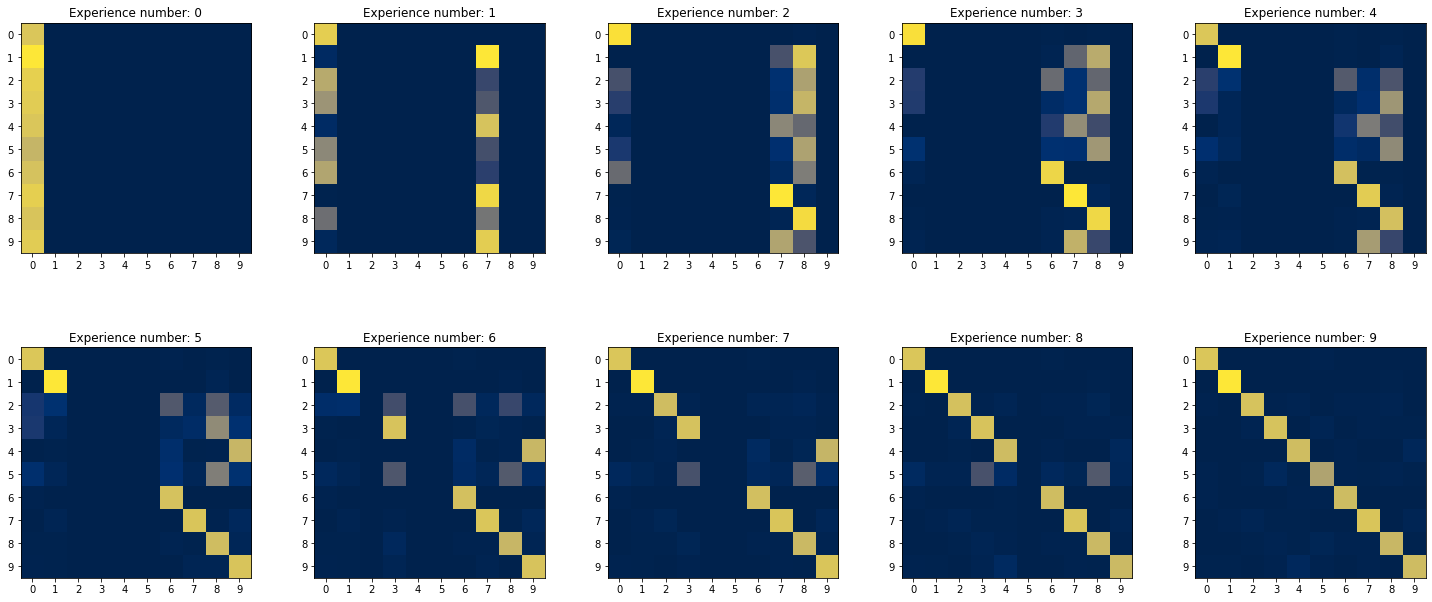

In [161]:
n_exp = len(results)

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2,5,i+1)
  #plt.tight_layout()
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap='cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

fig.tight_layout(h_pad=-50, w_pad=5)
plt.show()

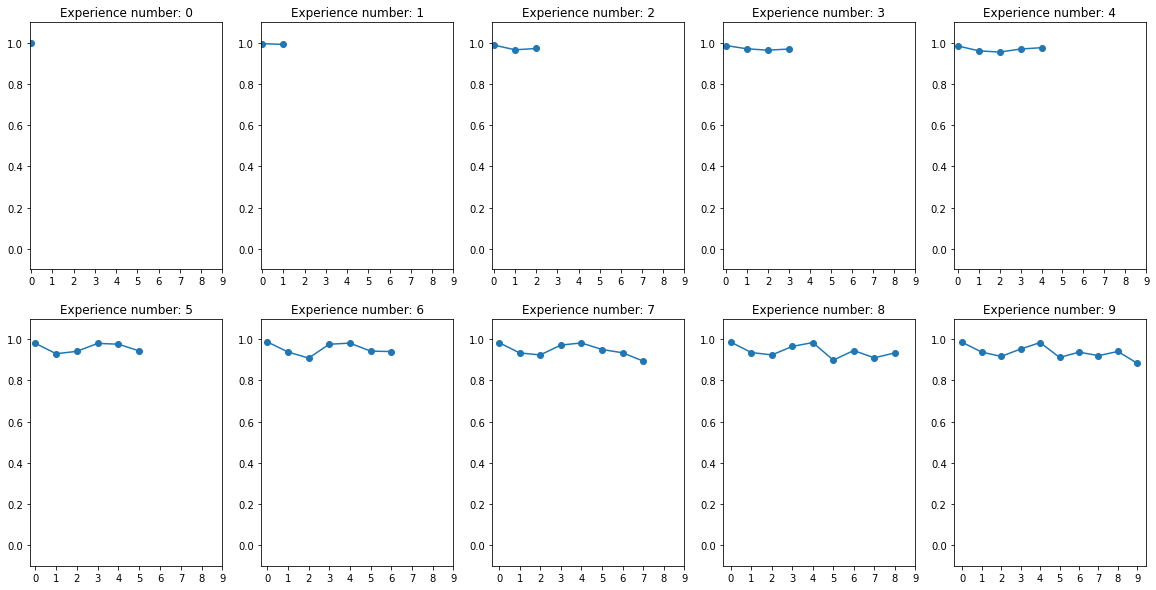

In [162]:
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']

acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt.show()



Possiamo facilmente osservare la sostanziale "risoluzione" del nostro problema. Ma questo non è Continual Learning! Proviamo a ripetere l'esperimento sullo stesso scenario ma con una diversa coppia modello-strategia. Vogliamo osservare il catastrophic forgetting, quindi scegliamo come strategia "Naive", ovvero continuare l'addestramento (anche detto "finetuning"). Come modello usiamo IncrementalClassifier, che ricalca ciò che abbiamo tentato prima, ovvero la modifica dell'ultimo strato neurale ogni volta che incontriamo una nuova classe.

In [163]:
from avalanche.models import IncrementalClassifier
from avalanche.training.strategies import Naive

scenario = SplitMNIST(n_experiences=10)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes, hidden_size=512)
model.classifier = IncrementalClassifier(in_features=512, initial_out_features=1)

print(model)

# log to text file
text_logger = TextLogger(open('log.txt', 'w'))


# CREATE THE STRATEGY INSTANCE
cl_strategy = Naive(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=128, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin)

# TRAINING LOOP
print('Starting experiment...')
results = []
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers=4))

SimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): IncrementalClassifier(
    (classifier): Linear(in_features=512, out_features=1, bias=True)
  )
)
Starting experiment...
Start of experience:  0
Current Classes:  [1]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
100%|██████████| 53/53 [00:00<00:00, 56.32it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0781
	Loss_MB/train_phase/train_stream/Task000 = 0.0035
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9969
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 12/12 [00:00<00:00, 43.61it/s]
> Eval on experience 0 (Tas

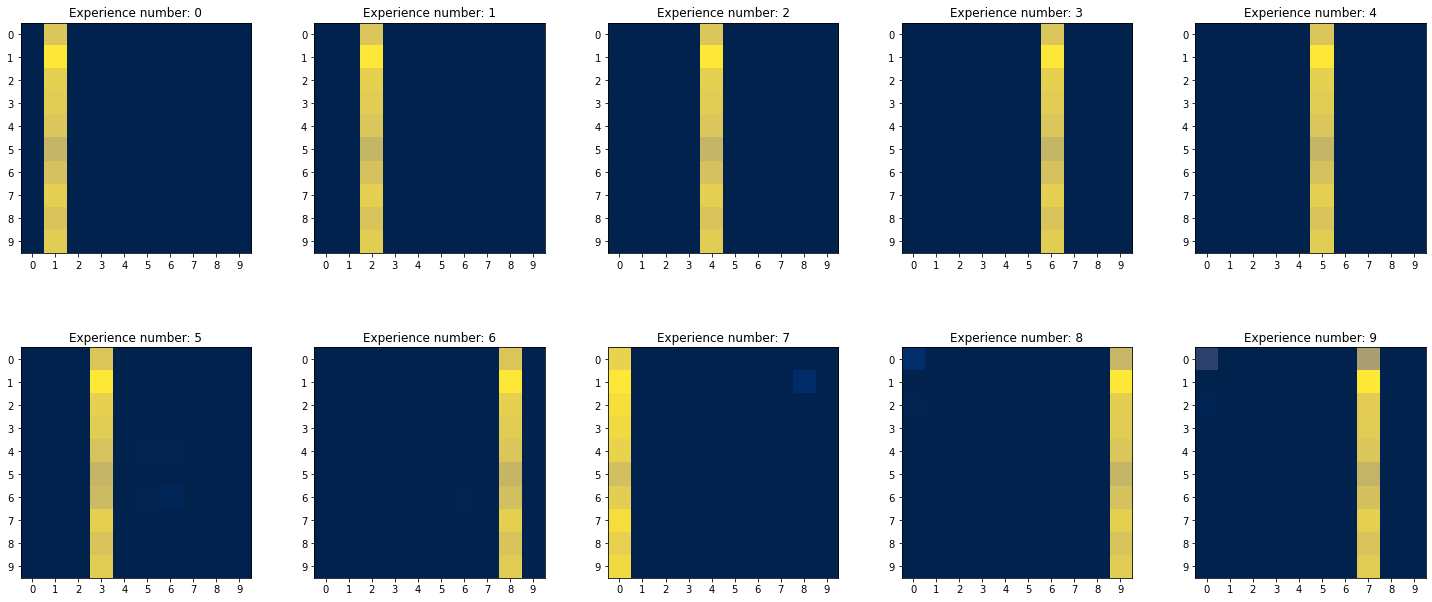

In [164]:
n_exp = len(results)

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2,5,i+1)
  #plt.tight_layout()
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap='cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

fig.tight_layout(h_pad=-50, w_pad=5)
plt.show()

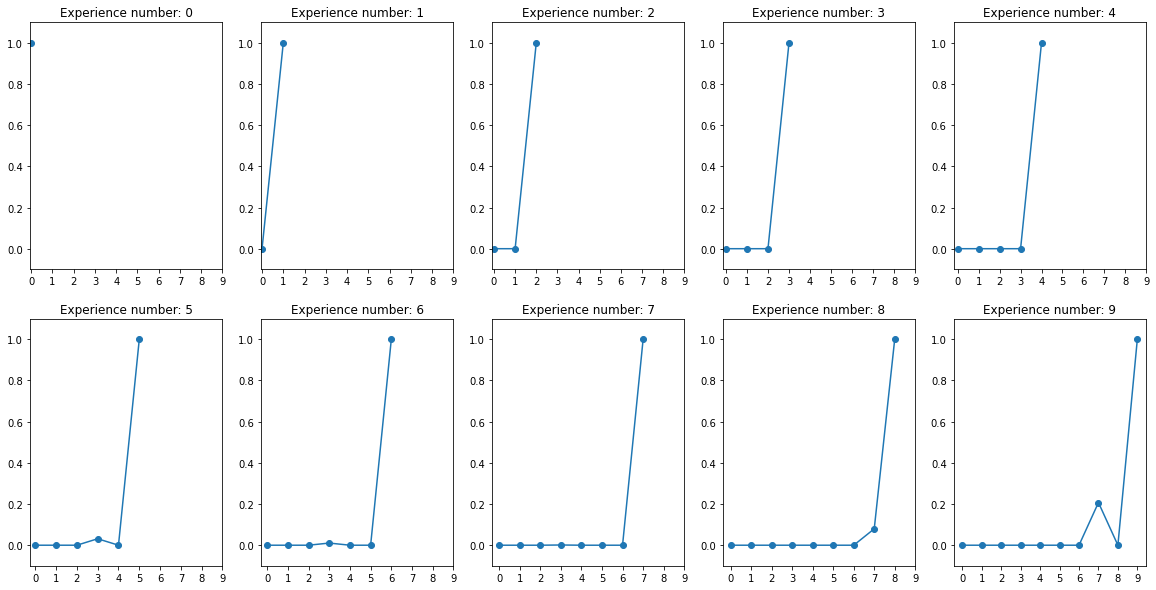

In [165]:
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']

acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt.show()



Non può esistere evidenza migliore della gravità del problema. L'approccio "naive" è fondamentalmente inadeguato. L'approccio "cumulativo" risolve il problema, ma è estremamente costo sotto tutti i punti di vista (tempo, spazio, risorse di calcolo).

## 4 - Approcci

Esistono 3 macro-categorie di approcci al problema del CL. Ognuna di esse ha vantaggi e svantaggi. Un punto importante da considerare è che fin'ora nessun modello proposto è riuscito a ottenere performance uguali all'approccio cumulativo. Per questo motivo, il CL può essere considerato ancora in una fase di "infanzia".

### Metodi basati sulla ripetizione

Invece di fare affidamento sull'interezza dei dati disponibili precedentemente, possiamo "ricordare" solo qualche sample tra quelli presentati. Questo permette di diminuire drasticamente la quantità di dati da immagazzinare. Viene poi effettuato un addestramento cumulativo con solo i sample salvati. In alternativa al salvataggio di alcuni sample mostrati, è possibile creare un modello generativo per ogni task, in modo da poter ricavare un numero arbitrario di sample sintetici durante le fasi successive di addestramento. Lo svantaggio principale è che non ci liberiamo dalla necessità di salvare dei sample (e ovviamente permerfmance e costo aumentano se si aumenta la dimensione della memoria) o l'aumentata complessità dovuta alla creazione di un modello generativo. Alcuni algoritmi afferenti a questa categoria traggono ispirazione dalle reti di CL per eccellenza, ovvero quelle animali, considerando l'apprendimento come dovuto anche al ricordo di eventi passati (per esempio durante il sonno).

Un esempio è l'algoritmo Gradient Episodic Memory (https://arxiv.org/pdf/1706.08840.pdf). Proviamolo:

In [172]:
from avalanche.training import GEM

scenario = SplitMNIST(n_experiences=10)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes, hidden_size=512)
model.classifier = IncrementalClassifier(in_features=512, initial_out_features=1)

print(model)

# log to text file
text_logger = TextLogger(open('log.txt', 'w'))


# CREATE THE STRATEGY INSTANCE
cl_strategy = GEM(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=256, train_epochs=1, eval_mb_size=100,
    evaluator=eval_plugin, patterns_per_exp=10)

# TRAINING LOOP
print('Starting experiment...')
results = []
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers=4))

SimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): IncrementalClassifier(
    (classifier): Linear(in_features=512, out_features=1, bias=True)
  )
)
Starting experiment...
Start of experience:  0
Current Classes:  [8]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
100%|██████████| 23/23 [00:00<00:00, 27.42it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6562
	Loss_MB/train_phase/train_stream/Task000 = 0.0099
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8515
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 32.27it/s]
> Eval on experience 0 (Tas

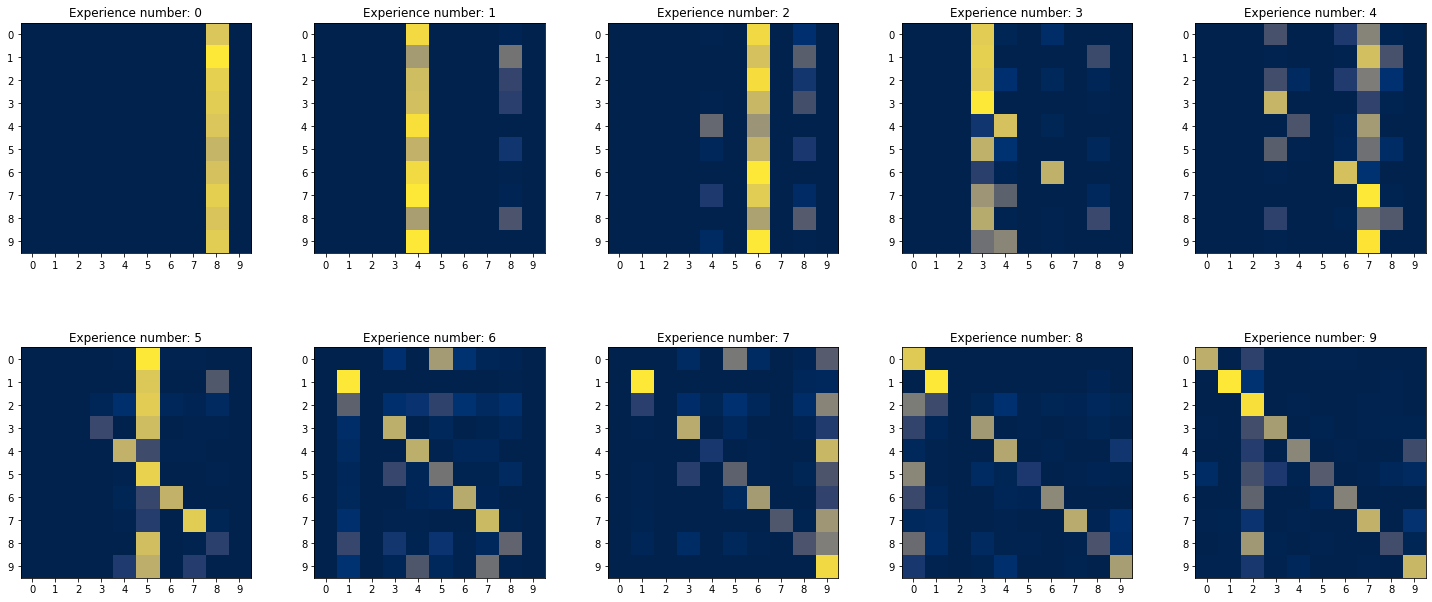

In [173]:
n_exp = len(results)

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2,5,i+1)
  #plt.tight_layout()
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap='cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

fig.tight_layout(h_pad=-50, w_pad=5)
plt.show()

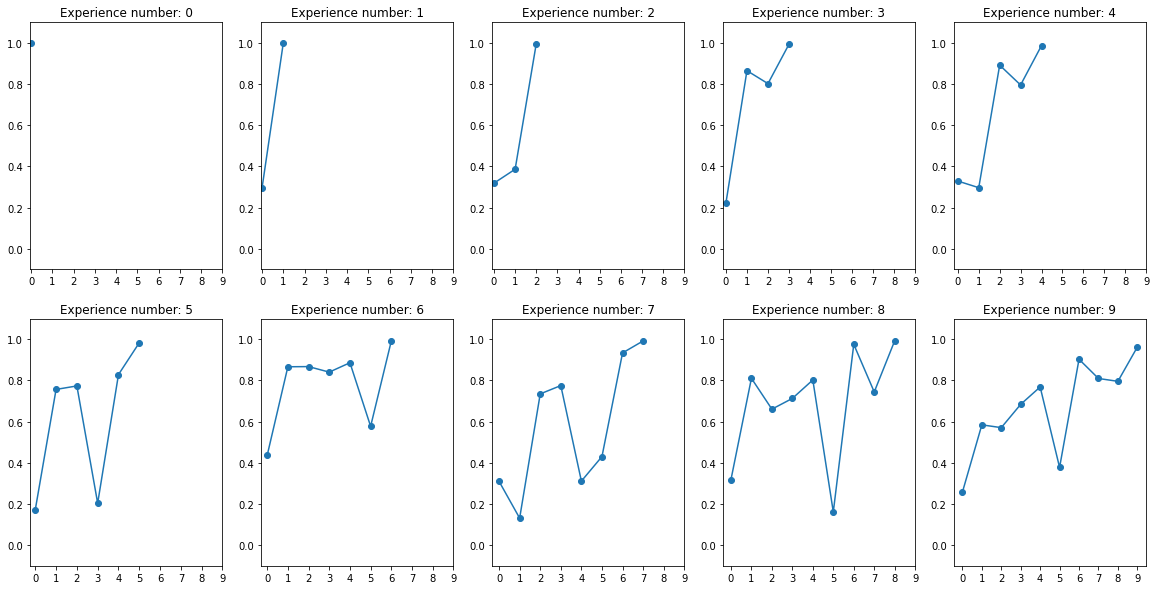

In [174]:
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']

acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt.show()

Per quanto non buoni quanto il valore di riferimento, siamo risuciti a limitare la dimenticanza di ciò che era già stato imparato! Abbiamo compiuto dei progressi, tuttavia ci sono ancora diversi approcci possibili.

### Metodi basati sulla regolarizzazione

Questo approccio si basa sulla modifica della funzione di loss, aggiungiendovi un termine basato sulla regolarizzazione. Lo scopo è quello di minimizzare la modifica dei parametri quando la loro traiettoria esce dallo spazio delle feature imparato in precedenza.

Uno degli esempi più noti è sicuramente Learning without Forgetting:

In [184]:
from avalanche.training import SynapticIntelligence

scenario = SplitMNIST(n_experiences=10)

# MODEL CREATION
model = SimpleMLP(num_classes=scenario.n_classes, hidden_size=512)


print(model)

# log to text file
text_logger = TextLogger(open('log.txt', 'w'))


# CREATE THE STRATEGY INSTANCE
cl_strategy = SynapticIntelligence(
    model, SGD(model.parameters(), lr=0.001, momentum=0.9),
    CrossEntropyLoss(), train_mb_size=256, train_epochs=2, eval_mb_size=100,
    evaluator=eval_plugin, si_lambda=1e-3, eps = 1e-3)

# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in scenario.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience, num_workers=4)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # eval also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(scenario.test_stream, num_workers=4))

SimpleMLP(
  (features): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Starting experiment...
Start of experience:  0
Current Classes:  [0]
-- >> Start of training phase << --
-- Starting training on experience 0 (Task 0) from train stream --
0it [00:00, ?it/s]

/home/luca/.local/lib/python3.8/site-packages/avalanche/training/plugins/synaptic_intelligence.py:62: UserWarning: The Synaptic Intelligence plugin is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn("The Synaptic Intelligence plugin is in an alpha stage "


100%|██████████| 24/24 [00:01<00:00, 23.76it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6298
	Loss_MB/train_phase/train_stream/Task000 = 0.0047
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8528
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 24/24 [00:01<00:00, 22.79it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0041
	Loss_MB/train_phase/train_stream/Task000 = 0.0044
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 1.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 10/10 [00:00<00:00, 30.59it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0020
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 1.0000
-- Starting eval on experien

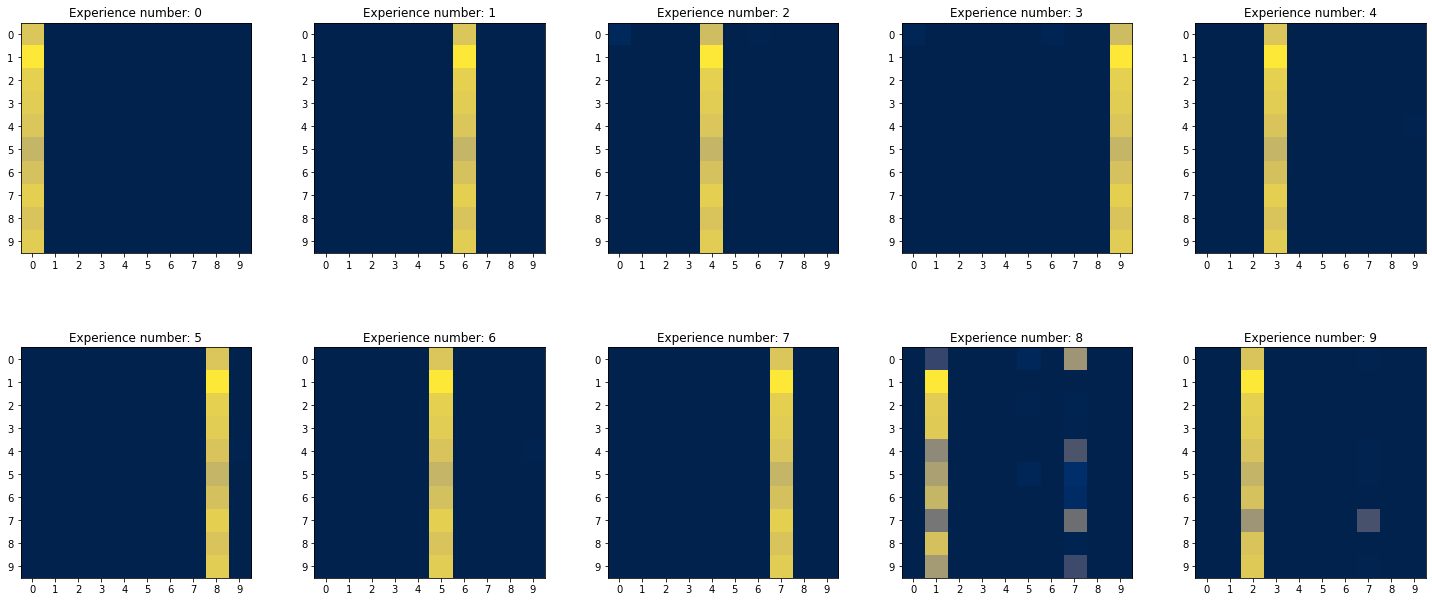

In [185]:
n_exp = len(results)

fig = plt.figure(figsize = (20,20))
for i,r in enumerate(results):
  plt.subplot(2,5,i+1)
  #plt.tight_layout()
  plt.imshow(r['ConfusionMatrix_Stream/eval_phase/test_stream'], cmap='cividis', interpolation = 'none')
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  plt.yticks(list(range(10)))
  fig.set_facecolor('white')

fig.tight_layout(h_pad=-50, w_pad=5)
plt.show()

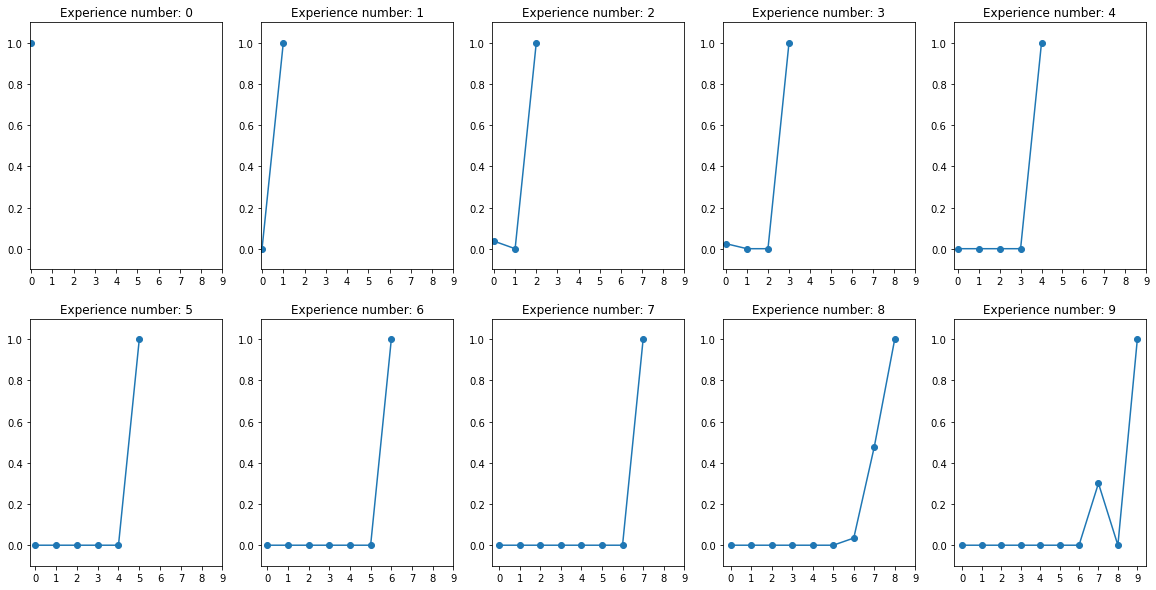

In [186]:
acc_keys = [n for n in keys if n[:-1] == 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00']

acc_matrix = []

for r in results:
    acc = [r[key] for key in acc_keys]
    acc_matrix.append(acc)

fig = plt.figure(figsize = (20,10))
for i,r in enumerate(acc_matrix):
  plt.subplot(2,5,i+1)
  plt.plot(r[:i+1], 'o-')
  plt.ylim(-0.1,1.1)
  plt.title("Experience number: {}".format(str(i)))
  plt.xticks(list(range(10)))
  fig.set_facecolor('white')

plt.show()



### Metodi basati sull'isolamento dei parametri

Con questo approccio i parametri vengono suddivisi in diversi insiemi, uno per ogni task. Spesso questi metodi richiedono l'esistenza di un "task oracle" che permette di usare solo i parametri rilevanti in ogni caso. Questo limita il campo di applicazione di tali metodologie.

L'implementazione di tali metodologie è banale ed è lasciata come esercizio al letto (a.k.a. ho finito il tempo e non posso implementarlo io)